# 프로젝트: 뉴스기사 요약해보기
***

# Step 1. 데이터 수집하기
***

데이터는 아래 링크에 있는 뉴스 기사 데이터(newssummarymore.csv)를 사용하세요.

In [1]:
# 라이브러리 import

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 데이터 다운

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
92861,"Yogi Adityanath govt renames Agra, Gorakhpur a...",The Yogi Adityanath-led government on Tuesday ...
15374,Pak govt officer steals Kuwait delegate's wall...,A Pakistani official was caught on Friday stea...
79783,"China our enemy, not Pakistan: SP supremo Mula...",Samajwadi Party supremo Mulayam Singh Yadav sa...
49013,Anupam Kher's account hacked with 'I Love Paki...,The Twitter accounts of actor Anupam Kher and ...
45725,"24,700 women abduction cases solved in Raj in ...",Rajasthan Home Minister Gulab Chand Kataria on...
18233,Fixing Facebook is going to take until 2019: M...,Facebook CEO Mark Zuckerberg on Friday said th...
49135,'World's loneliest bird' Nigel dies next to co...,"A gannet called Nigel, who was known as the wo..."
10061,"NASA, Autodesk unveil interplanetary lander co...",NASA's Jet Propulsion Laboratory and American ...
12721,"BoredElonMusk is my secret troll account, joke...",Replying to a Twitter account named 'BoredElon...
13968,"Sensex crashes 1,000 points; investors lose Ã¢...",Stock market investors lost as much as Ã¢ÂÂ¹4...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

# Step 2. 데이터 전처리하기 (추상적 요약)
***

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

In [4]:
# 중복 샘플과 null 값이 존재하는 샘플 제거

print('headline 열에서 중복을 베재한 샘플의 수 : ', data['headlines'].nunique())

print('Text 열에서 중복을 배제한 샘플의 수 : ', data['text'].nunique())

headline 열에서 중복을 베재한 샘플의 수 :  98280
Text 열에서 중복을 배제한 샘플의 수 :  98360


In [5]:
# 중복 데이터 제거

data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 text 수 :', (len(data)))

전체 text 수 : 98360


In [6]:
# null 값 확인

print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
# 텍스트 정규화

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [8]:
# 불용어 제거
# nltk_data/corpora/stopwords 을 불러오기

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수

def preprocess_sentence(sentence, remove_stopwords = True) : 
    # 텍스트 소문자화
    sentence = sentence.lower()
    
    # <br />, <a href = ...> 등의 html 태그 제거
    sentence = BeautifulSoup(sentence, "lxml").text
    
    # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    
    # 쌍따옴표 " 제거
    sentence = re.sub('"','', sentence)
    
    # 약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    
    # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub(r"'s\b","",sentence)
    
    # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("[^a-zA-Z]", " ", sentence) 
    
    # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
temp_text = "Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."
temp_summary = 'upGrad learner switches to career in ML & Al with 90% salary hike'

print(preprocess_sentence(temp_text))

# 불용어를 제거하지 않는다.
print(preprocess_sentence(temp_summary, False))  

saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
upgrad learner switches to career in ml al with salary hike


In [11]:
clean_text = []


# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [12]:
clean_headline = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headline.append(preprocess_sentence(s, False))

clean_headline[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [13]:
# null 값이 생겼는지 확인

data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
headline의 최소 길이 : 1
headline의 최대 길이 : 18
headline의 평균 길이 : 9.553660024400163


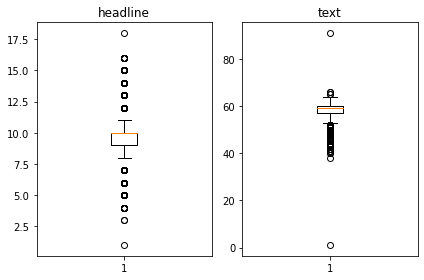

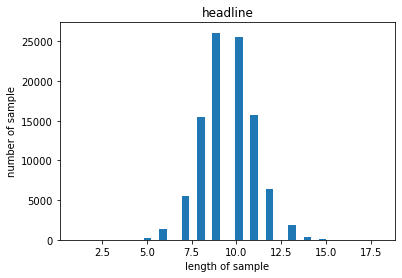

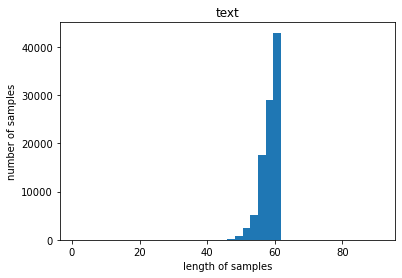

In [14]:
# 샘플의 최대 길이 정하기

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('headline의 최소 길이 : {}'.format(np.min(headline_len)))
print('headline의 최대 길이 : {}'.format(np.max(headline_len)))
print('headline의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
# text, headline 의 최대 길이 정하기

# 최대 길이가 길지 않아 다 포함하도록 설정

text_max_len = 91
headline_max_len = 18

In [16]:
# 몇 개의 샘플이 해당되는지 확인하기 위한 함수

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 91 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 18 이하인 샘플의 비율: 1.0


In [18]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가.

data['decoder_input'] = data['text'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['text'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...","sostoken Saurav Kant, an alumnus of upGrad and...","Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Kunal Shah's credit card bill payment...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand defeated India by 8 wicke...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...","sostoken With Aegon Life iTerm Insurance plan,...","With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,sostoken Speaking about the sexual harassment ...,Speaking about the sexual harassment allegatio...


In [19]:
# 디코더의 입력과 레이블을 numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [20]:
# 데이터 분리

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 8513 29423 41284 ... 35618 33326  2122]


In [21]:
# 정수 시퀀스를 이용해 데이터의 샘플 순서를 정의

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [22]:
# 섞인 데이터를 학습용 데이터와 테스트 데이터로 분리, 8:2로 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19672


In [23]:
#  테스트 데이터 갯수를 이용, 전체 데이터를 양분

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [24]:
# 단어 집합 생성

# 토크나이저 정희

src_tokenizer = Tokenizer()

# 입력된 데이터로부터 단어 집합 생성

src_tokenizer.fit_on_texts(encoder_input_train)

In [25]:
# 빈도수가 7미만인 단어 확인

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 91307
등장 빈도가 6번 이하인 희귀 단어의 수: 66508
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24799
단어 집합에서 희귀 단어의 비율: 72.83997941012188
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.725402949991386


In [26]:
# 단어 집합의 크기 제한

src_vocab = 24000

# 단어 집합의 크기를 24,000으로 제한
src_tokenizer = Tokenizer(num_words = src_vocab) 

# 단어 집합 재생성.
src_tokenizer.fit_on_texts(encoder_input_train) 

In [27]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[41, 3450, 358, 3969, 7, 124, 166, 218, 728, 2, 6310, 165, 35, 458, 66, 12480, 670, 6, 1645, 221, 418, 3284, 2456, 422, 2573, 23, 827, 354, 931, 1320, 6, 754, 2992, 1936, 5, 1, 105, 8503, 448, 6, 211, 6311, 10, 1, 105, 40, 675, 2, 1446, 1, 2993, 9, 965, 878, 9482, 4, 1, 264, 53, 71], [4, 3, 52, 321, 302, 4, 266, 661, 18308, 6312, 3008, 34, 273, 589, 1, 8504, 204, 2027, 34, 819, 84, 44, 3707, 79, 87, 84, 7909, 2, 1, 794, 56, 820, 229, 1, 3008, 319, 6251, 51, 22, 1, 302, 10, 466, 3, 545, 255, 10, 11, 794, 8, 184, 33, 1959, 2, 38, 924, 1, 3008, 1574], [1, 6677, 706, 5, 1, 2118, 702, 1151, 73, 10037, 1096, 7, 54, 11040, 18, 156, 153, 3, 21503, 648, 45, 3373, 7, 155, 1, 11040, 34, 69, 118, 2, 2336, 24, 5776, 11, 56, 10209, 26, 172, 117, 20229, 6, 26, 33, 722, 19, 1683, 1, 702, 869, 18, 136, 107, 1, 54, 6901, 8, 6134, 601, 172, 10409]]


In [28]:
# 전체 단어 집합과 가가 단어에 대한 빈도수 계산 

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [29]:
# 빈도가 6 미만인 단어수 확인

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 91308
등장 빈도가 5번 이하인 희귀 단어의 수: 64293
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 27015
단어 집합에서 희귀 단어의 비율: 70.4133263240899
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.401732164576605


In [30]:
# 단어 집합 제한

tar_vocab = 26000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[12, 43, 3452, 360, 3971, 7, 126, 168, 220, 730, 2, 6312, 167, 37, 460, 68, 12482, 672, 6, 1647, 223, 420, 3286, 2458, 424, 2575, 25, 829, 356, 933, 1322, 6, 756, 2994, 1938, 5, 1, 107, 8505, 450, 6, 213, 6313, 10, 1, 107, 42, 677, 2, 1448, 1, 2995, 9, 967, 880, 9484, 4, 1, 266, 55, 73], [12, 4, 3, 54, 323, 304, 4, 268, 663, 18310, 6314, 3010, 36, 275, 591, 1, 8506, 206, 2029, 36, 821, 86, 46, 3709, 81, 89, 86, 7911, 2, 1, 796, 58, 822, 231, 1, 3010, 321, 6253, 53, 24, 1, 304, 10, 468, 3, 547, 257, 10, 11, 796, 8, 186, 35, 1961, 2, 40, 926, 1, 3010, 1576], [12, 1, 6679, 708, 5, 1, 2120, 704, 1153, 75, 10039, 1098, 7, 56, 11042, 20, 158, 155, 3, 21505, 650, 47, 3375, 7, 157, 1, 11042, 36, 71, 120, 2, 2338, 26, 5778, 11, 58, 10211, 28, 174, 119, 20231, 6, 28, 35, 724, 21, 1685, 1, 704, 871, 20, 138, 109, 1, 56, 6903, 8, 6136, 603, 174, 10411], [12, 56, 196, 1598, 450, 5, 8631, 12828, 1131, 129, 1128, 734, 22, 1, 365, 380, 2044, 6, 100, 11, 1, 934, 34, 57, 8, 416, 29, 3, 122

In [31]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [32]:
# 패딩하기

encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headline_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
***

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [33]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [34]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [35]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 91)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 91, 128)      3072000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 91, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [36]:
# 어텐션 매커니즘 

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [37]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 
# 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 91)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 91, 128)      3072000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 91, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
308/308 [==============================] - 237s 770ms/step - loss: 6.8363 - val_loss: 6.4557
Epoch 2/50
308/308 [==============================] - 237s 768ms/step - loss: 6.1991 - val_loss: 6.0362
Epoch 3/50
308/308 [==============================] - 236s 765ms/step - loss: 5.8111 - val_loss: 5.6784
Epoch 4/50
308/308 [==============================] - 236s 766ms/step - loss: 5.5614 - val_loss: 5.4821
Epoch 5/50
308/308 [==============================] - 237s 768ms/step - loss: 5.3298 - val_loss: 5.2855
Epoch 6/50
308/308 [==============================] - 237s 769ms/step - loss: 5.0995 - val_loss: 5.1254
Epoch 7/50
308/308 [==============================] - 236s 767ms/step - loss: 4.8166 - val_loss: 4.8399
Epoch 8/50
308/308 [==============================] - 238s 771ms/step - loss: 4.3822 - val_loss: 4.0408
Epoch 9/50
308/308 [==============================] - 237s 768ms/step - loss: 3.7095 - val_loss: 2.8602
Epoch 10/50
308/308 [==============================] - 237s 768m

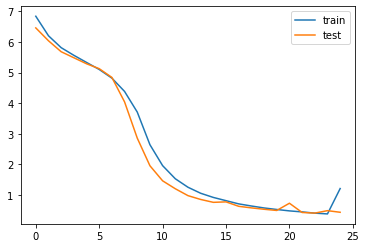

In [39]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [40]:
# 인퍼런스 모델 구현

# 원문 단어 집합에서 정수 -> 단어를 얻음
src_index_to_word = src_tokenizer.index_word

# 요약 단어 집합에서 단어 -> 정수를 얻음
tar_word_to_index = tar_tokenizer.word_index 

# 요약 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word = tar_tokenizer.index_word 

In [41]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 
# 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [42]:
# 어텐션 메커니즘을 사용하는 출력층 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [43]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [44]:
# 모델 테스트

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headline(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
***

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

In [45]:
# 50개 샘플에 대해 실제 요약과 예측 요약 비교

for i in range(50, 100):
    print("헤드라인 요약:", seq2headline(decoder_input_test[i]))
    print("예측 원문 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("원문 :", seq2text(encoder_input_test[i]))
    print("\n")

헤드라인 요약: result it's a rigged election she added earlier she said imran will hand over the country to extremists 
예측 원문 요약 :  it's a dictator election she added earlier she said imran will hand over the country to extremists
원문 : after imran khan's pakistan tehreek e insaf emerged as the single largest party with 116 seats in pakistan general elections the cricketer turned ex wife reham khan has said the army will now run the country's foreign office i am not surprised it was a predictable result it's a rigged election she added earlier she said imran will hand over the country to extremists 


헤드라인 요약: old to a hotel where she drugged him and dumped him into yamuna river while he was unconscious 
예측 원문 요약 :  the 23 where she fails him and dumped him into regular river while he was unconscious
원문 : a 20 year old woman and her fiancãâ© were arrested for murdering her ex boyfriend in up's mathura the woman claimed her ex boyfriend had been threatening to post nude pictures of her online

예측 원문 요약 :  year old has also received a demerit point for breaching the icc code of conduct the icc
원문 : indian fast bowler ishant sharma has been fined 15 of his match fee for his animated send off to england's in the first test at edgbaston officials deemed that the send off had the potential to provoke an aggressive reaction from the departing batsman the 29 year old has also received a demerit point for breaching the icc code of conduct 


헤드라인 요약: of offering them sweets the woman overcame her suicidal tendency three years ago through counselling according to reports 
예측 원문 요약 :  the woman was
원문 : amid the metoo movement a 40 year old meghalaya woman has accused two catholic church priests of sexual abuse she accused one of them of sexually abusing her after she turned five years old and the other of inappropriately touching victims under the guise of offering them sweets the woman overcame her suicidal tendency three years ago through counselling according to reports 


헤드라인 요약

예측 원문 요약 :  by sp meanwhile yadav said the morcha will contest the 2019 lok sabha elections elections
원문 : samajwadi secular morcha founder shivpal yadav has said he is open to the idea of joining a proposed grand alliance of opposition parties in uttar pradesh yadav who had formed the morcha following differences with samajwadi party chief akhilesh yadav had earlier said he felt neglected by sp meanwhile yadav said the morcha will contest the 2019 lok sabha elections 


헤드라인 요약: was slammed by cm pinarayi vijayan for the issue while health minister kk shailaja called the act ridiculous 
예측 원문 요약 :  he was slammed by cm pinarayi vijayan for the issue while health minister siddaramaiah called the act
원문 : indian union muslim league mla abdulla attended the kerala assembly on monday wearing a mask and gloves to highlight the impact of the nipah virus abdulla said this was a symbolic gesture as everyone in kozhikode was wearing masks he was slammed by cm pinarayi vijayan for the issue whi

예측 원문 요약 :  married men offered career advice and suggested they could share it with her alone late at night
원문 : in a facebook post about sexual harassment faced by women facebook coo sheryl sandberg revealed that she also experienced sexual harassment over the course of her job adding that she was lucky she wasn't harassed by anyone she worked for she said old married men offered career advice and suggested they could share it with her alone late at night 


헤드라인 요약: will cover 50 islands and 34 000 square kilometres and its first phase will be completed in 2022 
예측 원문 요약 :  50 islands and 34 000 square kilometres and its first phase will be completed in 2022
원문 : saudi arabia is planning a tourism project on an area bigger than belgium the country hopes to turn part of its red sea coastline into a global tourism destination governed by laws on par with international standards the project will cover 50 islands and 34 000 square kilometres and its first phase will be completed in 2022

# Step 5. Summa을 이용해서 추출적 요약해보기
***

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [47]:
# summarize 임포트

from summa.summarizer import summarize

In [54]:
# 데이터 가져오기

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data_summa = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [59]:
# text 컬럼의 0번째 인덱스 값 (내용)

print(data_summa['text'][0])

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.


In [58]:
# text 컬럼의 0번째 인덱스 값 요약

print('text :', end ='')
print(summarize(data_summa['text'][1], ratio = 0.5))

text :Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


### 회고
***

NLP 는 CV 에 비해 단계도 복잡하고 너무 어려운 것 같다... ㅜㅜ

사실 어느 것 하나 쉬운게 없다 ㅠㅠ